# Introduction
This notebook is used to create figure 7 from the paper

In [1]:
import pandas as pd
import geopandas as gpd

import osmnx as ox
import networkx as nx

from shapely.geometry import Point
from shapely.geometry import LineString
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt

## Load the data

In [ ]:
path = './data/'

In [2]:
voronoi=gpd.read_file(path + 'voronoi_antenas.shp')

In [3]:
bike=gpd.read_file(path + 'Red_Ciclorruta.shp')

In [4]:
new_bike=gpd.read_file(path + 'PlanImplementacionCicloruta2018_2019.shp')

In [5]:
percolation=gpd.read_file(path + 'no_bike_latent_v17_giantF521.shp')

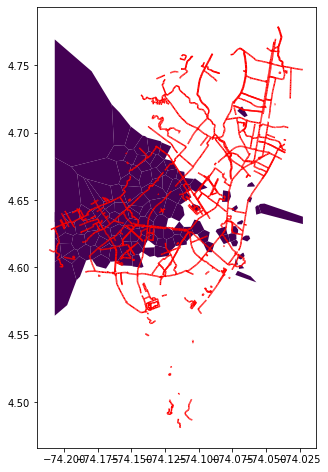

In [6]:
base=voronoi[voronoi['partition']==2].plot(column='partition',figsize=(5,10))
bike.plot(ax=base,color='r')

In [8]:
crs_used="+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
voronoi_prj=voronoi.to_crs(crs_used)
bike_prj=bike.to_crs(crs_used)
new_bike_prj=new_bike.to_crs(crs_used)
percolation_prj=percolation.to_crs(crs_used)

In [9]:
# Calculate the lenght of each segment
bike_prj.loc[:,'length']=bike_prj['geometry'].length
new_bike_prj.loc[:,'length']=new_bike_prj['geometry'].length
percolation_prj.loc[:,'length']=percolation_prj['geometry'].length

In [10]:
percolation_prj.head(2)

,source,target,weight,geometry,length
0,315097235,312100831,2796,LINESTRING (598955.0145896744 504636.265930306...,32.161793
1,315097235,5099140149,2796,LINESTRING (598955.0145896744 504636.265930306...,42.838862


### Calculation of bikefacility lenght inside each community

In [11]:
partitions=sorted(list(voronoi['partition'].unique()))

In [12]:
bike_length=[]
for part in partitions:
    bike_length.append(gpd.sjoin(voronoi_prj[voronoi_prj['partition']==part],bike_prj, how='inner',op='intersects')\
                       ['length'].sum())
new_bike_length=[]
for part in partitions:
    new_bike_length.append(gpd.sjoin(voronoi_prj[voronoi_prj['partition']==part],new_bike_prj, how='inner',op='intersects')\
                       ['length'].sum())
perc_length=[]
for part in partitions:
    perc_length.append(gpd.sjoin(voronoi_prj[voronoi_prj['partition']==part],percolation_prj, how='inner',op='intersects')\
                       ['length'].sum())

C:\Users\sol\Anaconda3\envs\ox\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


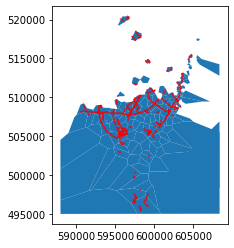

In [13]:
#Check the result
com_1=gpd.sjoin(voronoi_prj[voronoi_prj['partition']==1],bike_prj, how='inner',op='intersects')['OBJECTID'].tolist()
base=voronoi_prj[voronoi_prj['partition']==1].plot()
bike_prj[bike_prj['OBJECTID'].isin(com_1)].plot(ax=base,color='r')

In [14]:
# voronoi_area=gpd.read_file(r'C:\Users\sol\Documents\01-bikes_bogota\01-data\Shapefiles\voronoi_area.shp')

In [15]:
# voronoi_area_prj=voronoi_area.to_crs(crs_used)

In [16]:
# voronoi_area_prj.loc[:,'area']=voronoi_area_prj['geometry'].area

In [17]:
# result['area_km2']=voronoi_area_prj.groupby('partition')[['area']].sum()/1000000

In [18]:
nodes=pd.read_csv(path + 'nodes_all_trips.csv')

In [19]:
nodes.head(3)

,Unnamed: 0,id,Label,wstrato,Longitude,Latitude,pop,income_level
0,0,1.0,1.0,3.000000,-74.1205,4.61808,17197.0,2.0
1,1,2.0,2.0,1.860132,-74.1327,4.56084,24609.0,1.0
2,2,3.0,3.0,2.116675,-74.1358,4.58827,8108.0,1.0


In [20]:
# Add strata and population to each antena
merge=pd.merge(voronoi,nodes[['id','wstrato','pop']],left_on='antena_id',right_on='id',how='left')

### Biko datapoints Departures

In [21]:
data=pd.read_csv('data_parsed_20190221.csv')
# filter the data that has stays greater than  so that we consider only moving people
data=data[data['stays']>0]
data.loc[:,'new_activity_id']=data['activity_id'].astype('str')+'-'+data['stays'].astype('int').astype('str')

In [22]:
data_departures=data.drop_duplicates(subset='new_activity_id',keep='first')

In [23]:
voronoi.head(2)

,antena_id,partition,pos,lat,lon,geometry
0,643.0,1,"(4.49311, -74.1099)",4.49311,-74.1099,"POLYGON ((-74.11799395039682 4.47804, -74.1255..."
1,647.0,1,"(4.50018, -74.1021)",4.50018,-74.1021,POLYGON ((-74.09340209667127 4.482746323060248...


In [24]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
crs='+init=epsg:4326'
geometry=[Point(xy) for xy in zip(data_departures.lon, data_departures.lat)]
data_dep_geo=GeoDataFrame(data_departures,crs=crs,geometry=geometry)

In [25]:
biko_from=gpd.sjoin(data_dep_geo[['geometry','new_activity_id']],voronoi[['geometry','partition','antena_id']],how='left', op='intersects')

C:\Users\sol\Anaconda3\envs\ox\lib\site-packages\geopandas\tools\sjoin.py:56: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [26]:
biko_from.rename(columns={'partition':'partition_from','antena_id':'antena_from'},inplace=True)
biko_from.drop(['geometry','index_right'],axis=1,inplace=True)

In [27]:
biko_from.drop_duplicates('new_activity_id',inplace=True)

In [28]:
biko_from.set_index('new_activity_id',inplace=True)

### Biko datapoints Destinations

In [29]:
data_destinations=data.drop_duplicates(subset='new_activity_id',keep='last')

In [30]:
geometry=[Point(xy) for xy in zip(data_destinations.lon, data_destinations.lat)]
data_dest_geo=GeoDataFrame(data_destinations,crs=crs,geometry=geometry)

In [31]:
biko_to=gpd.sjoin(data_dest_geo[['geometry','new_activity_id']],voronoi[['geometry','partition','antena_id']],how='left', op='intersects')

In [32]:
biko_to.rename(columns={'partition':'partition_to','antena_id':'antena_to'},inplace=True)
biko_to.drop(['geometry','index_right'],axis=1,inplace=True)

In [33]:
biko_to.head(2)

,new_activity_id,partition_to,antena_to
329,1875716-1,0.0,177.0
640,1876707-1,0.0,526.0


In [34]:
# There are 4 mistakes in the shapefile from the voronoi. 2 are big but occur on the mountains and the other 2 are small
biko_to.drop_duplicates('new_activity_id',inplace=True)

In [35]:
biko_to.set_index('new_activity_id',inplace=True)

In [36]:
biko_to['partition_from']=biko_from['partition_from']
biko_to['antena_from']=biko_from['antena_from']

In [37]:
biko_od=biko_to

### Create the result table

In [55]:
result=pd.DataFrame(index=[],columns=[])

In [56]:
result['partition']=sorted(voronoi['partition'].unique())

In [57]:
result.set_index('partition',inplace=True)

In [58]:
result['wstrato']=merge.groupby('partition')[['wstrato']].mean()['wstrato']

In [60]:
result['bike_length']=bike_length
result['bike_length']=result['bike_length']/1000
result['new_bike_length']=new_bike_length
result['new_bike_length']=result['new_bike_length']/1000
result['existing_new_length']=(result['bike_length']+result['new_bike_length'])
result['percolation_length']=perc_length
result['final_bp']=result['existing_new_length']+result['percolation_length']

In [63]:
trips=pd.read_csv(path + 'LinksLatAll_LogNorm_Gamma.csv')

In [65]:
# Inside trips for latent
for part in partitions:
    nodes_part=voronoi[voronoi['partition']==part]['antena_id'].tolist()
    trips_inside=trips[(trips['Source'].isin(nodes_part))&(trips['Target'].isin(nodes_part))]['Weight'].sum()
    result.loc[part,'trips_inside']=trips_inside

In [68]:
result=result.loc[0:3,:]

In [70]:
table=result[['wstrato','existing_new_length','trips_inside','final_bp']].round(4)
table.rename(columns={'wstrato':'Mean Strata',
                      'existing_new_length':'Exiting and projected bike lanes(km)',\
                      'trips_inside':'Latent trips inside community',},inplace=True)

In [71]:
table['community']=[4,1,2,3]

In [72]:
table.set_index('community',inplace=True)

In [75]:
with open('mytable.tex','w') as tf:
    tf.write(table.to_latex())

In [76]:
color=['#7EBEDE','#FAB082','#E6EDAF', '#F27474']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

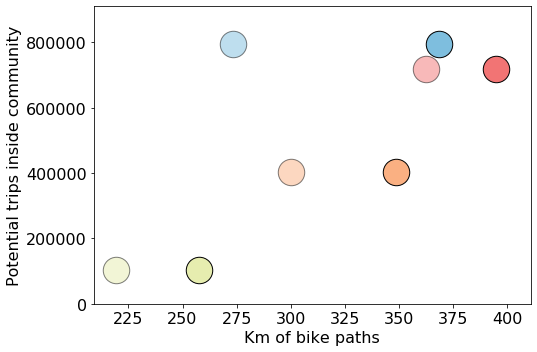

In [77]:
# Latent inside and all bike facilities
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(131)
for part in sorted(table.index):
    now_plot=ax.scatter(table['Exiting and projected bike lanes(km)'][part],\
                    table['Latent trips inside community'][part],s=700,\
                    c=color[part-1],edgecolors='black',alpha=0.5)

for part in sorted(table.index):
    now_plot=ax.scatter(table['final_bp'][part],table['Latent trips inside community'][part],s=700,\
                        c=color[part-1],edgecolors='black',alpha=1)
    
ax.set_xlabel('Km of bike paths',size=16)
ax.set_ylabel('Potential trips inside community',size=16)
ax.tick_params('both',labelsize=16)
ax.set_ylim([0,910000])
plt.tight_layout()
plt.savefig('./img/communiti_table.eps', format='eps', dpi=1000)